## Task Duration and Network Centrality

In [131]:
from research_utils.database.database import Database

import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
import seaborn as sns
import scipy.stats as stats

### Read in Data

Read in the data for the regression model from the `reqs_prioritization` table in Postgres. This table is a compilation of all the issues opened in 2018 for networks for which fewer than 50% of the issues were submitted by non-contributors.

In [2]:
database = Database()

In [330]:
sql = """
SELECT a.package_id, a.package, a.organization,
	   a.duration_median, a.duration_mean, a.project_age,
	   b.crowd_pct, b.crowd, b.total as total_issues,
	   c.gini_coefficient, c.avg_clustering, c.avg_min_path,
	   d.total_contributors
FROM(
	SELECT package_id, package, organization,
		   PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY duration) AS duration_median,
		   AVG(duration) AS duration_mean,
		   EXTRACT(DAY FROM NOW() - MIN(created_at)) AS project_age
	FROM(
		SELECT package_id, organization, package, created_at,
			   EXTRACT(DAY FROM closed_at - created_at) as duration
		FROM open_source.issues
		WHERE closed_at IS NOT NULL
		
	) z
	GROUP BY package_id, organization, package
) a
INNER JOIN open_source.crowd_percentage b
ON a.package_id = b.package_id
INNER JOIN (
	SELECT organization, package, gini_coefficient, avg_clustering, avg_min_path, crowd_pct
	FROM open_source.stakeholder_networks
) c
ON (a.package = c.package AND a.organization = c.organization)
INNER JOIN (
	SELECT COUNT(DISTINCT user_id) as total_contributors, package_id
	FROM open_source.issue_contributors
    WHERE commit_pct > 0
	GROUP BY package_id
) d
ON a.package_id = d.package_id
"""
#AND 'bug' = ANY(lower(labels::text)::text[])
df = pd.read_sql(sql, database.connection)

In [331]:
len(df)

566

### Exploratory Data Analysis

Some simple analysis to get a feel for patterns in the data.

In [332]:
df.describe()

,duration_median,duration_mean,project_age,crowd_pct,crowd,total_issues,gini_coefficient,avg_clustering,avg_min_path,total_contributors
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,7.517668,70.691376,1928.024735,0.481664,54.353357,121.826855,0.562252,0.601783,2.187906,11.588339
std,30.772167,69.394051,748.388962,0.264284,88.181604,148.517292,0.048243,0.140696,0.231761,10.642799
min,0.000000,0.637462,285.000000,0.006711,1.000000,30.000000,0.285714,0.000000,1.400000,1.000000
25%,1.000000,28.398181,1450.750000,0.265306,19.250000,48.000000,0.535624,0.523466,2.012506,5.000000
50%,2.000000,51.197803,1946.000000,0.500000,34.000000,76.500000,0.569206,0.628980,2.147529,9.000000
75%,7.000000,89.225893,2475.000000,0.702228,66.000000,141.750000,0.592266,0.706336,2.331743,15.000000
max,624.000000,615.919753,5537.000000,0.985294,1670.000000,1913.000000,0.696200,0.878524,3.054147,86.000000


In [333]:
len(df)

566

In [334]:
df['crowd_pct'] = df['crowd_pct'] * 100
df['gini_coefficient'] = df['gini_coefficient'] * 100
df['avg_clustering'] = df['avg_clustering'] * 100
df['project_age'] = df['project_age']/30.5

In [335]:
reg_df = df[df['duration_mean'] < 203]
len(reg_df)/len(df)

0.9487632508833922

### OLS Sanity Check

Before getting into our more complicated model, we want to run an OLS model just to get a feel for how the model is working.

In [354]:
y, X = dmatrices('duration_mean ~ '
                 'crowd_pct + total_issues + project_age + total_contributors + '
                 'gini_coefficient + avg_clustering + avg_min_path',
                 data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
print(res.get_robustcov_results(cov_type='HC3').summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     34.66
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           3.71e-40
Time:                        00:41:34   Log-Likelihood:                -3100.2
No. Observations:                 566   AIC:                             6216.
Df Residuals:                     558   BIC:                             6251.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -27.5680     37

Text(0, 0.5, 'Count')

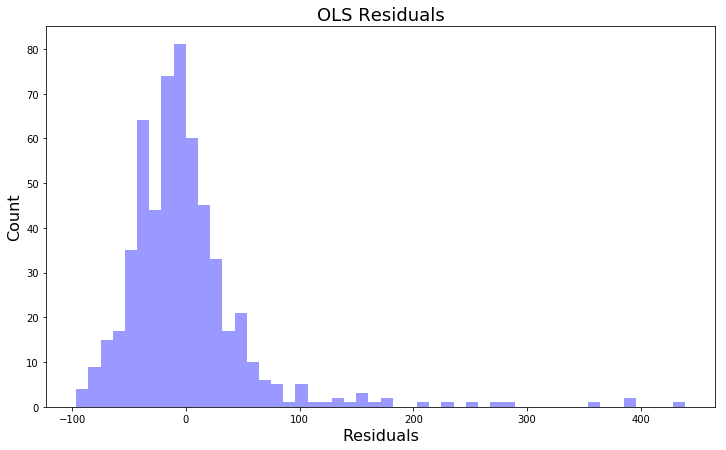

In [355]:
plt.figure(figsize=(12, 7))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

Text(0, 0.5, 'Mean Duration')

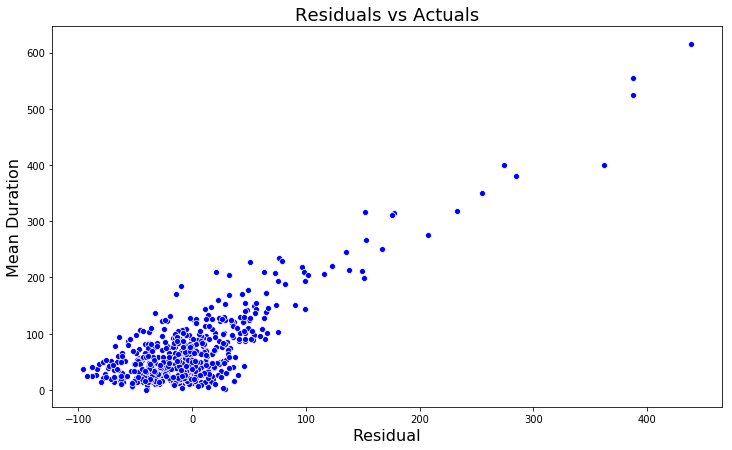

In [356]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=res.resid, y=df['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residual', fontsize=16)
plt.ylabel('Mean Duration', fontsize=16)

In [357]:
glm_gamma = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.inverse_power))
glm_results = glm_gamma.fit()
print(glm_results.summary())

2019-07-29 00:42:17,011 [19242] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.

2019-07-29 00:42:17,021 [19242] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)



                 Generalized Linear Model Regression Results                  
Dep. Variable:          duration_mean   No. Observations:                  566
Model:                            GLM   Df Residuals:                      558
Model Family:                   Gamma   Df Model:                            7
Link Function:          inverse_power   Scale:                         0.66401
Method:                          IRLS   Log-Likelihood:                -3107.9
Date:                Mon, 29 Jul 2019   Deviance:                       606.14
Time:                        00:42:17   Pearson chi2:                     371.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0280      0

(-150, 400)

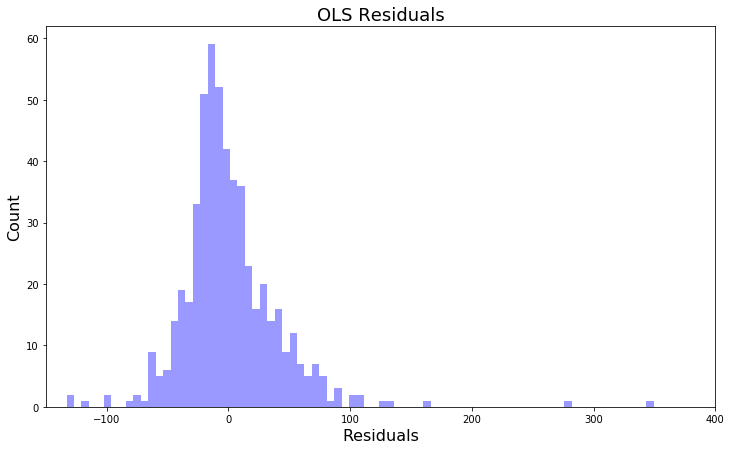

In [341]:
plt.figure(figsize=(12, 7))
sns.distplot(glm_results.resid_response, kde=False, color='blue', bins=100)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-150, 400])

In [358]:
glm_gamma2 = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.identity))
glm_results2 = glm_gamma2.fit()
print(glm_results2.summary())

2019-07-29 00:42:25,804 [19242] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.

2019-07-29 00:42:25,812 [19242] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)



                 Generalized Linear Model Regression Results                  
Dep. Variable:          duration_mean   No. Observations:                  566
Model:                            GLM   Df Residuals:                      558
Model Family:                   Gamma   Df Model:                            7
Link Function:               identity   Scale:                         0.57436
Method:                          IRLS   Log-Likelihood:                -2812.3
Date:                Mon, 29 Jul 2019   Deviance:                       244.63
Time:                        00:42:25   Pearson chi2:                     320.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -36.2653     22

(-150, 400)

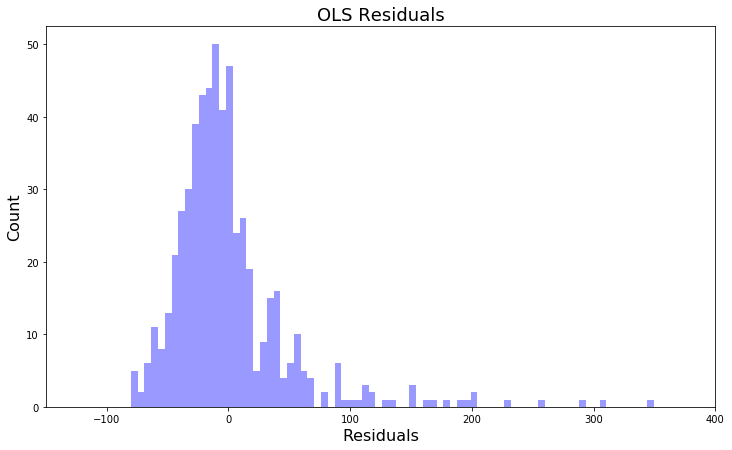

In [359]:
plt.figure(figsize=(12, 7))
sns.distplot(glm_results2.resid_response, kde=False, color='blue', bins=100)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-150, 400])

In [360]:
glm_gamma3 = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
glm_results3 = glm_gamma3.fit()
print(glm_results3.summary())

2019-07-29 00:42:29,172 [19242] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



                 Generalized Linear Model Regression Results                  
Dep. Variable:          duration_mean   No. Observations:                  566
Model:                            GLM   Df Residuals:                      558
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.57334
Method:                          IRLS   Log-Likelihood:                -2808.4
Date:                Mon, 29 Jul 2019   Deviance:                       240.38
Time:                        00:42:29   Pearson chi2:                     320.
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8817      0

(-150, 400)

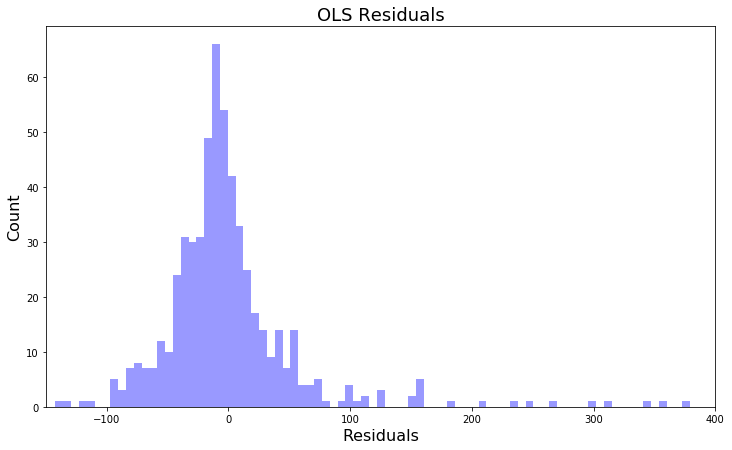

In [361]:
plt.figure(figsize=(12, 7))
sns.distplot(glm_results3.resid_response, kde=False, color='blue', bins=100)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-150, 400])